In [ ]:
cd /content/drive/MyDrive/Colab_Notebooks/cv_project2

/content/drive/MyDrive/Colab_Notebooks/cv_project2


In [ ]:
import torch
import os
import pandas as pd
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import skimage.morphology
import torch.nn as nn
from tqdm import tqdm
from torch.nn.functional import relu
import torch.optim as optim
# Install torchmetrics
from torchmetrics.classification import MulticlassJaccardIndex as iou
from collections import OrderedDict
ignore_index=250
%load_ext autoreload
%autoreload 2
os.makedirs("./figs/", exist_ok=True)
# Ignore warnings
import warnings
warnings.filterwarnings("ignore")
plt.ion()   # interactive mode

In [ ]:
class Cells(Dataset):

    def __init__(self, csv_file_images, csv_file_masks, root_dir):
        """
        Arguments:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.images = pd.read_csv(csv_file_images, header = None)
        self.masks = pd.read_csv(csv_file_masks, header = None)
        self.root_dir = root_dir

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_name = os.path.join(self.root_dir, 'images/', str(self.images[0][idx]))
        mask_name = os.path.join(self.root_dir, 'masks/', str(self.masks[0][idx]))
        image = io.imread(img_name)
        image = image.astype(np.float32) #pytorch wants it to be float
        image = image- np.mean(image, axis=0) /  np.std(image, axis=0) #normalize

        mask = io.imread(mask_name)
        # Keep first channel only
        mask = mask[:,:,0]
        # Label independent connected components
        mask = skimage.morphology.label(mask)
        mask = mask.astype(np.float32)
        image = image[None, :] # add extra channels dimension
        mask = mask[None, :]
        mask[np.where(mask>0)] = 1 #make it binary (cell or background)
        sample = (image, mask)
        return sample

(1, 520, 696)
(1, 520, 696)
(1, 520, 696)
(1, 520, 696)


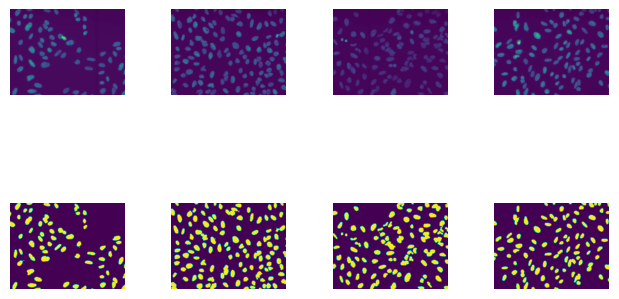

In [ ]:
train_dataset = Cells(csv_file_images='/content/drive/MyDrive/Colab_Notebooks/cv_project2/csvs/train_images.csv',
                    csv_file_masks = '/content/drive/MyDrive/Colab_Notebooks/cv_project2/csvs/train_masks.csv',
                    root_dir='/content/drive/MyDrive/Colab_Notebooks/cv_project2/')
val_dataset = Cells(csv_file_images='/content/drive/MyDrive/Colab_Notebooks/cv_project2/csvs/validate_images.csv',
                    csv_file_masks = '/content/drive/MyDrive/Colab_Notebooks/cv_project2/csvs/validate_masks.csv',
                    root_dir='/content/drive/MyDrive/Colab_Notebooks/cv_project2/')
test_dataset = Cells(csv_file_images='/content/drive/MyDrive/Colab_Notebooks/cv_project2/csvs/test_images.csv',
                    csv_file_masks = '/content/drive/MyDrive/Colab_Notebooks/cv_project2/csvs/test_masks.csv',
                    root_dir='/content/drive/MyDrive/Colab_Notebooks/cv_project2/')

fig = plt.figure()

for i, sample in enumerate(train_dataset):
    ax = plt.subplot(2, 4, i + 1)
    plt.tight_layout()
    ax.axis('off')
    ax.imshow(sample[0].squeeze())
    ax = plt.subplot(2, 4, i + 5)
    plt.tight_layout()
    ax.axis('off')
    ax.imshow(sample[1].squeeze())
    print(sample[1].shape)

    if i == 3:
        plt.show()
        break


In [ ]:
!pip install torchmetrics

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
class UNet(nn.Module):

    def __init__(self, in_channels=3, out_channels=1, init_features=32):
        super(UNet, self).__init__()

        features = init_features
        self.encoder1 = UNet._block(in_channels, features, name="enc1")
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.encoder2 = UNet._block(features, features * 2, name="enc2")
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.encoder3 = UNet._block(features * 2, features * 4, name="enc3")
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.encoder4 = UNet._block(features * 4, features * 8, name="enc4")
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)

        # self.bottleneck = UNet._block(features * 8, features * 16, name="bottleneck")
        self.bottleneck = UNet._block(features * 4, features * 8, name="bottleneck")

        self.upconv4 = nn.ConvTranspose2d(
            features * 16 , features * 8 , kernel_size=2, stride=2
        )
        self.decoder4 = UNet._block((features * 8) * 2, features * 8, name="dec4")
        self.upconv3 = nn.ConvTranspose2d(
            features * 8, features * 4, kernel_size=2, stride=2
        )
        self.decoder3 = UNet._block((features * 4) * 2, features * 4, name="dec3")
        self.upconv2 = nn.ConvTranspose2d(
            features * 4, features * 2, kernel_size=2, stride=2
        )
        self.decoder2 = UNet._block((features * 2) * 2, features * 2, name="dec2")
        self.upconv1 = nn.ConvTranspose2d(
            features * 2, features, kernel_size=2, stride=2
        )
        self.decoder1 = UNet._block(features * 2, features, name="dec1")

        self.conv = nn.Conv2d(
            in_channels=features, out_channels=out_channels, kernel_size=1
        )

    def forward(self, x):
        enc1 = self.encoder1(x)
        enc2 = self.encoder2(self.pool1(enc1))
        enc3 = self.encoder3(self.pool2(enc2))
        # enc4 = self.encoder4(self.pool3(enc3))

        bottleneck = self.bottleneck(self.pool3(enc3))

        # dec4 = self.upconv4(bottleneck)
        # print(dec4.shape, enc4.shape)
        # dec4 = torch.cat((dec4, enc4), dim=1)
        # dec4 = self.decoder4(dec4)
        dec3 = self.upconv3(bottleneck)
        dec3 = torch.cat((dec3, enc3), dim=1)
        dec3 = self.decoder3(dec3)
        dec2 = self.upconv2(dec3)
        dec2 = torch.cat((dec2, enc2), dim=1)
        dec2 = self.decoder2(dec2)
        dec1 = self.upconv1(dec2)
        dec1 = torch.cat((dec1, enc1), dim=1)
        dec1 = self.decoder1(dec1)
        return torch.sigmoid(self.conv(dec1))

    @staticmethod
    def _block(in_channels, features, name):
        return nn.Sequential(
            OrderedDict(
                [
                    (
                        name + "conv1",
                        nn.Conv2d(
                            in_channels=in_channels,
                            out_channels=features,
                            kernel_size=3,
                            padding=1,
                            bias=False,
                        ),
                    ),
                    (name + "norm1", nn.BatchNorm2d(num_features=features)),
                    (name + "relu1", nn.ReLU(inplace=True)),
                    (
                        name + "conv2",
                        nn.Conv2d(
                            in_channels=features,
                            out_channels=features,
                            kernel_size=3,
                            padding=1,
                            bias=False,
                        ),
                    ),
                    (name + "norm2", nn.BatchNorm2d(num_features=features)),
                    (name + "relu2", nn.ReLU(inplace=True)),
                ]
            )
        )

In [ ]:
model = UNet(in_channels=1, out_channels=1, init_features=32)

In [ ]:
def validate(model, val_loader, device, criterion, metric):
    loss_step, metric_step = [], []
    model.eval()

    with torch.no_grad():
        for inp_data, labels in val_loader:
            # Move imgs and labels to gpu
            labels = labels.to(device)
            inp_data = inp_data.to(device)
            # Forward pass
            outputs = model(inp_data)
            # Calculate and record loss and metrics
            metric_step.append(metric(outputs, labels).item())
            loss_step.append(criterion(outputs, labels).item())

    val_loss_epoch = np.mean(loss_step)
    val_metric = np.mean(metric_step)
    return val_loss_epoch, val_metric

In [ ]:
def train_one_epoch(model, optimizer, train_loader, device, criterion, metric):
    loss_step, metric_step = [], []
    model.train()
    for (inp_data, labels) in train_loader:
        # Move imgs and labels to gpu
        labels = labels.to(device)
        inp_data = inp_data.to(device)
        # Forward pass
        outputs = model(inp_data)
        loss = criterion(outputs, labels)
        # Compute gradients and update parameters
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # Compute and record metric and loss
        metric_step.append(metric(outputs, labels).item())
        loss_step.append(loss.item())

    loss_curr_epoch = np.mean(loss_step)
    train_metric = np.mean(metric_step)
    return loss_curr_epoch, train_metric

In [ ]:
def train(model, optimizer, num_epochs, train_loader, val_loader, device, criterion, metric, exp_name='unet'):
    best_val_metric = -1
    model = model.to(device)
    dict_log = {"train_metric":[], "val_metric":[], "train_loss":[], "val_loss":[]}
    pbar = tqdm(range(num_epochs))
    for epoch in pbar:
        train_loss, train_metric = train_one_epoch(model, optimizer, train_loader, device, criterion, metric)
        val_loss, val_metric,  = validate(model, val_loader, device, criterion, metric)
        msg = (f'Ep {epoch}/{num_epochs}: metric : Train:{train_metric:.3f} \t Val:{val_metric:.2f}\
                || Loss: Train {train_loss:.3f} \t Val {val_loss:.3f}')

        pbar.set_description(msg)

        dict_log["train_metric"].append(train_metric)
        dict_log["val_metric"].append(val_metric)
        dict_log["train_loss"].append(train_loss)
        dict_log["val_loss"].append(val_loss)

        if val_metric > best_val_metric:
            best_val_metric = val_metric
            torch.save({
                  'epoch': epoch,
                  'model_state_dict': model.state_dict(),
                  'optimizer_state_dict': optimizer.state_dict(),
                  'loss': val_loss,
                  'metric':val_metric,
                  }, f'{exp_name}_best_model_min_val_loss.pth')

    return dict_log

In [ ]:
import torch.nn.functional as F

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

train_loader_test = DataLoader(
    train_dataset,
    batch_size = 4,
    shuffle=True,
    num_workers = 2,
    pin_memory = True)

val_loader_test = DataLoader(
    val_dataset,
    batch_size = 4,
    shuffle=False,
    num_workers = 1)

print(len(train_dataset), len(val_dataset))
imgs, segs = next(iter(train_loader_test))
preds  = model(imgs)

# Compute mIoU
metric = iou(num_classes=2)
print("mIoU %:", metric(preds,segs).item()*100)

# Compute cross-entropy loss
criterion = nn.BCELoss()
print("Cross-entropy loss",criterion(preds,segs).item())

# How to visualize the predictions
img_id = 3
pred = preds.argmax(dim=1)[img_id,...]
img, seg = imgs[img_id,...], segs[img_id,...]
print(pred.shape, img.shape, seg.shape, img.min(), img.max(), seg.min(), seg.max())

100 50
mIoU %: 39.756542444229126
Cross-entropy loss 0.6090084910392761
torch.Size([520, 696]) torch.Size([1, 520, 696]) torch.Size([1, 520, 696]) tensor(112.5879) tensor(1543.7438) tensor(0.) tensor(1.)


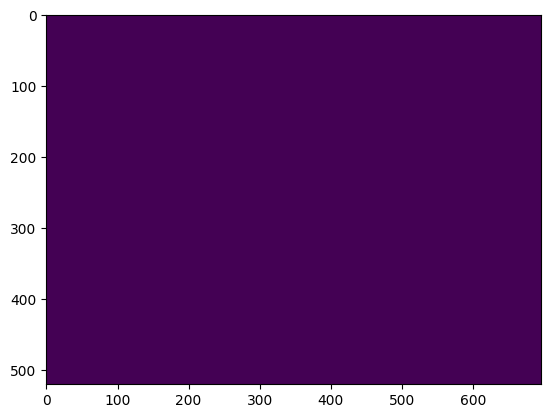

In [ ]:
plt.imshow(pred)

In [ ]:
def plot_stats(dict_log, modelname="",baseline=None, title=None, scale_metric=100):
    plt.figure(figsize=(15,10))
    fontsize = 14
    plt.subplots_adjust(hspace=0.3)
    plt.subplot(2,1,1)
    x_axis = list(range(len(dict_log["val_metric"])))

    y_axis_train = [i * scale_metric for i in dict_log["train_metric"]]
    y_axis_val = [i * scale_metric for i in dict_log["val_metric"]]
    plt.plot(y_axis_train, label=f'{modelname} Train mIoU')
    plt.scatter(x_axis, y_axis_train)

    plt.plot( y_axis_val, label=f'{modelname} Validation mIoU')
    plt.scatter(x_axis, y_axis_val)

    plt.ylabel('mIoU in %')
    plt.xlabel('Number of Epochs')
    plt.title("mIoU over epochs", fontsize=fontsize)
    if baseline is not None:
        plt.axhline(y=baseline, color='red', label="Acceptable performance")
    plt.legend(fontsize=fontsize, loc='best')

    plt.subplot(2,1,2)
    plt.plot(dict_log["train_loss"] , label="Training")


    plt.scatter(x_axis, dict_log["train_loss"], )
    plt.plot(dict_log["val_loss"] , label='Validation')
    plt.scatter(x_axis, dict_log["val_loss"])

    plt.ylabel('Loss value')
    plt.xlabel('Number of Epochs')
    plt.title("Loss over epochs", fontsize=fontsize)
    plt.legend(fontsize=fontsize, loc='upper right')


The metric didn't work but the loss is going down and the model is learning

Ep 49/50: metric : Train:0.401 	 Val:0.40                || Loss: Train 0.041 	 Val 0.042: 100%|██████████| 50/50 [11:12<00:00, 13.45s/it]


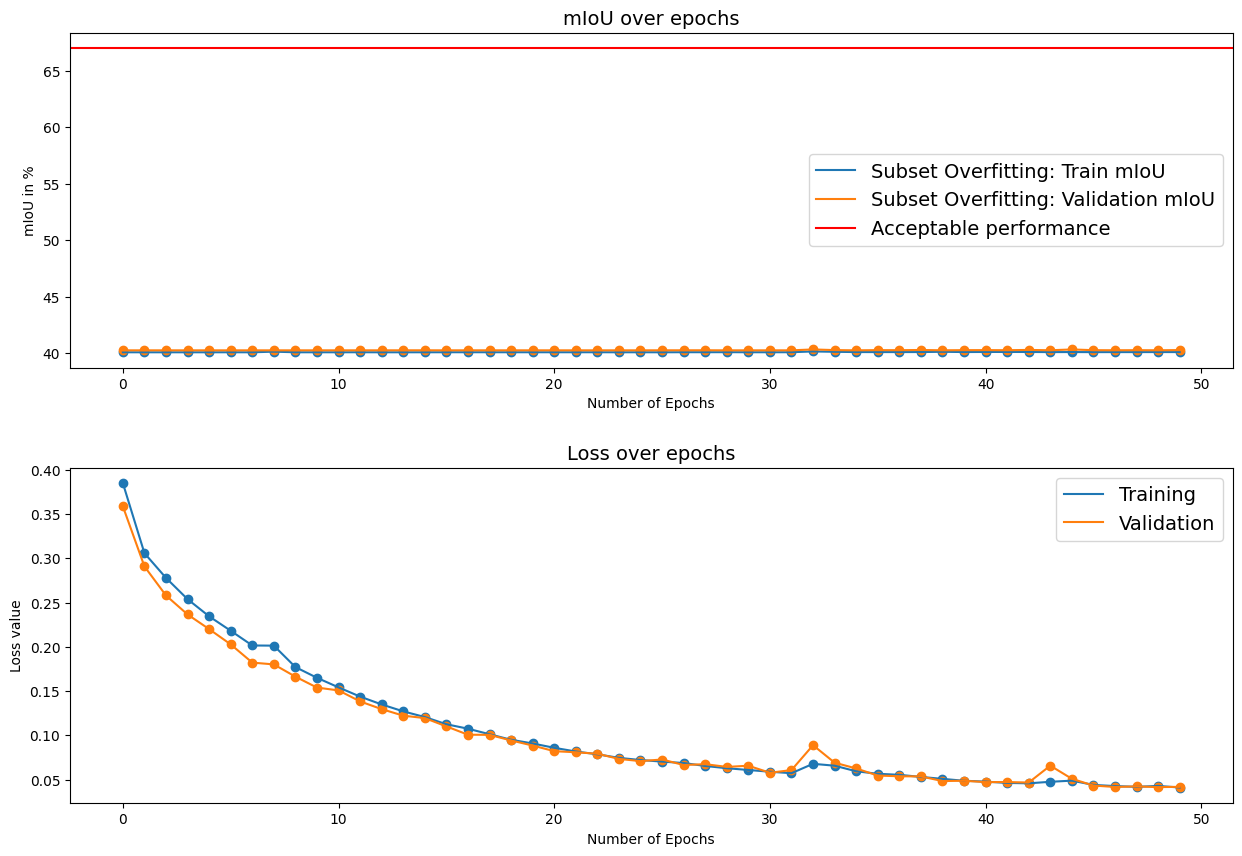

In [ ]:
optimizer = optim.Adam(model.parameters(), lr=3e-4)
criterion = nn.BCELoss()
metric = iou(num_classes=2).to(device)
epochs = 50
dict_log = train(model, optimizer, epochs, train_loader_test, val_loader_test, device, criterion, metric, exp_name='UNet-ce-ovefit')
plot_stats(dict_log, modelname="Subset Overfitting:", baseline=67, scale_metric=100, title="./figs/so")


In [ ]:
torch.save({'model_state_dict': model.state_dict()}, 'best_model.pth')

In [ ]:
test_loader_test = DataLoader(
    test_dataset,
    batch_size = 4,
    shuffle=False,
    num_workers = 1)

# Testing on unseen data

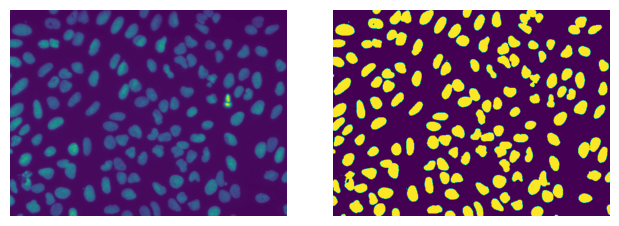

In [ ]:
model.eval()
imgs, segs = next(iter(test_loader_test))

preds = model(imgs.to(device))

ax = plt.subplot(1, 2, 1)
plt.tight_layout()
ax.axis('off')
ax.imshow(imgs[0].cpu().detach().squeeze())
ax = plt.subplot(1, 2, 2)
plt.tight_layout()
ax.axis('off')
ax.imshow(torch.round(preds[0].cpu().detach().squeeze()))
